In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random
from collections import defaultdict

import energyflow
from particle import Particle
import pennylane as qml
from tqdm import tqdm

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Linear, BatchNorm1d
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset
from torch_geometric.utils import to_networkx
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

import wandb

In [2]:
os.chdir('..');
# print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss
from qssl.training.trainer import run_model, train_model
from qssl.data.data_loader import preprocess_fixed_nodes, create_contrastive_graph_pairs
from qssl.data.data_preprocessing_augmentation import drop_nodes, drop_edges, mask_features, graph_augment
from qssl.utils.utils import visualize_graph_pairs, visualize_graph_pairs_01, plot_and_save_loss

In [3]:
n_connections = 6
input_dims = 8
hidden_dims = [64,32,32]
output_dims = 8
n_qubits = 6
q_depth = 1
epochs = 50
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [4]:
X = np.load(r'data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'data/qg_graph/y10_sorted_12500.npy')
N=12500

In [5]:
x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y, nodes_per_graph=8)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 592.49it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:20<00:00, 613.27it/s]


In [6]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data[i]))

original_dataset = dataset

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 7647.54it/s]


In [7]:
pairs, labels = create_contrastive_graph_pairs(dataset)

In [8]:
# run = wandb.init(
#     project = "ML4Sci-QuantumContrastiveLearning",
#     config = {
#         "dataset":"QG12500",
#         "model":"QGNN",
#         "loss":"contrastive pair loss"
#     }
# )

Error: You must call wandb.init() before wandb.log()

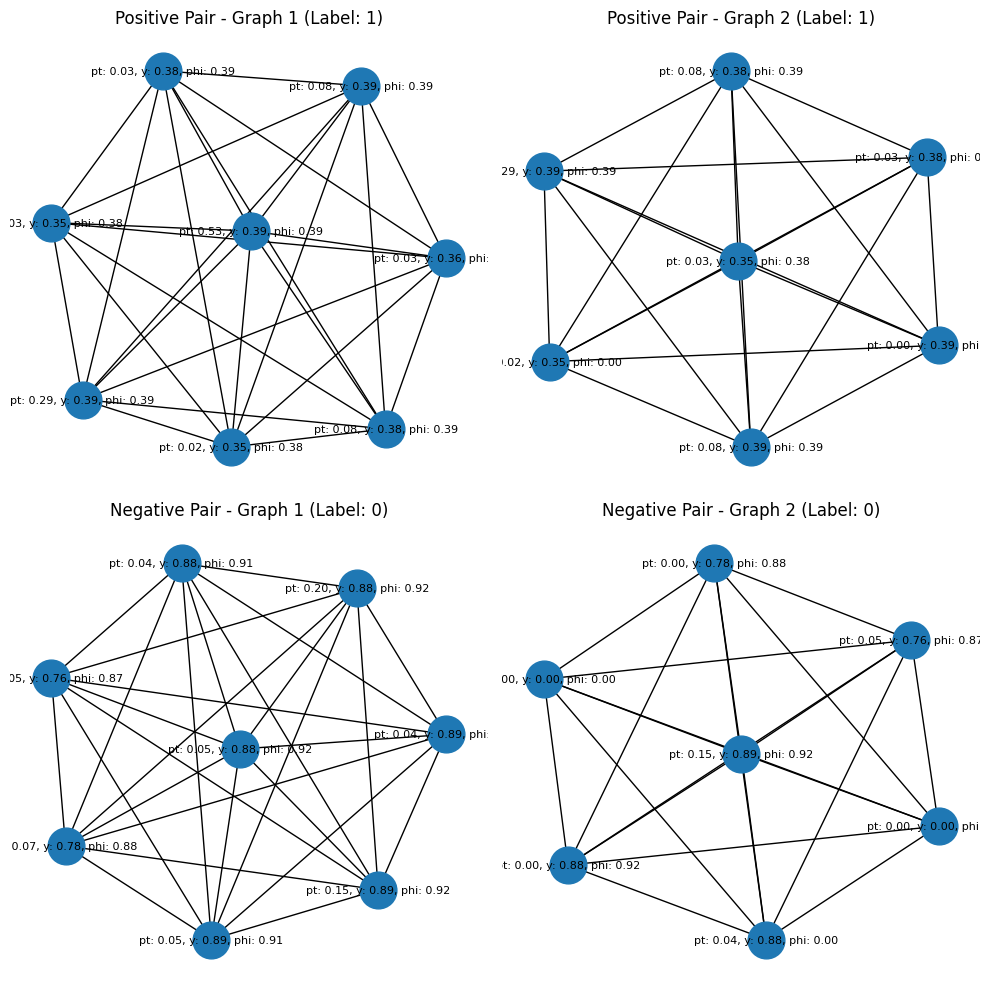

In [9]:
visualize_graph_pairs_01(pairs, labels)

In [10]:
class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  
        self.labels = labels 
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label

In [11]:
def split_pairs(pairs, labels, train_ratio, val_ratio):
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [12]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
from qssl.models.qc import quantum_circuit_angle_entangle_inputs

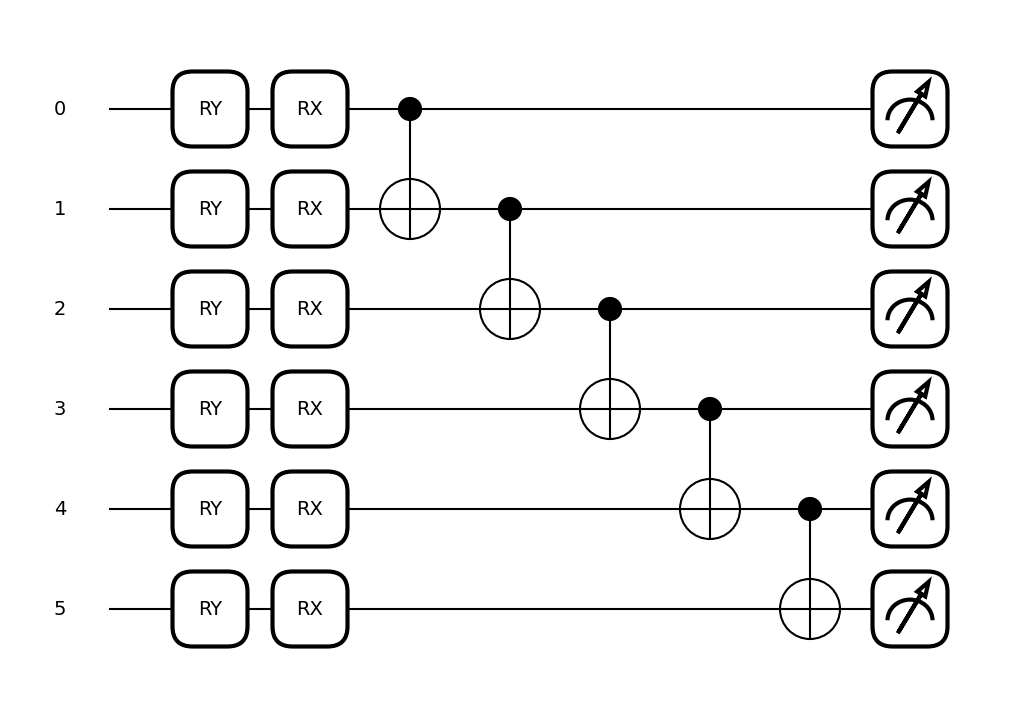

In [14]:
example_inputs = torch.rand(n_qubits)
weights = np.random.random((1, n_qubits))
X=[1,2,3,4]
# quantum_circuit_angle_entangle(example_inputs,weights,5)

# Draw the circuit
fig, ax = qml.draw_mpl(quantum_circuit_angle_entangle_inputs)(example_inputs)
# wandb.log({"QGNN Quantum Circuit": wandb.Image(fig)})
plt.show()

In [15]:
# Define the quantum layer using Pennylane

class QuantumLayer(torch.nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):  # Apply quantum circuit on each input in the batch
            qc_output = quantum_circuit_angle_entangle_inputs(x[i])
            # Convert the list output to a tensor
            q_out.append(torch.tensor(qc_output, dtype=torch.float32))
        return torch.stack(q_out)

In [16]:
# Hybrid Quantum-Classical GNN model
class HybridQuantumGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        self.norm_layers = []
        self.residual_projections = []  # To project residuals if needed
        
        # Initial GAT Layer
        layers.append(GATConv(input_dims, hidden_dims[0]))
        self.norm_layers.append(BatchNorm1d(hidden_dims[0]))
        if input_dims != hidden_dims[0]:
            self.residual_projections.append(Linear(input_dims, hidden_dims[0]))
        else:
            self.residual_projections.append(None)
        
        # Additional Graph Layers with Residuals and Normalization
        for i in range(len(hidden_dims) - 1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            self.norm_layers.append(BatchNorm1d(hidden_dims[i+1]))
            if hidden_dims[i] != hidden_dims[i+1]:
                self.residual_projections.append(Linear(hidden_dims[i], hidden_dims[i+1]))
            else:
                self.residual_projections.append(None)
        
        self.layers = ModuleList(layers)
        self.norm_layers = ModuleList(self.norm_layers)
        self.residual_projections = ModuleList(self.residual_projections)
        self.activ_fn = activ_fn
        
        # Quantum Layer
        self.quantum_layer = QuantumLayer()

        # Classical Readout Layer
        self.readout_layer = Linear(hidden_dims[-1] * 2 + n_qubits, output_dims)  # Combining GNN and quantum outputs
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            residual = h  # Residual connection
            h = self.layers[i](h, edge_index)
            h = self.norm_layers[i](h)
            h = self.activ_fn(h)
            h = self.dropout(h)
            
            # Project residual if needed
            if self.residual_projections[i] is not None:
                residual = self.residual_projections[i](residual)
            
            h = h + residual  # Adding residual connection
        
        # Multi-head readout: mean pooling + max pooling
        h_mean = global_mean_pool(h, batch)
        h_max = global_max_pool(h, batch)
        h_gnn = torch.cat([h_mean, h_max], dim=1)

        # Quantum layer output
        h_quantum = self.quantum_layer(h_gnn)

        # Combine GNN and quantum layer outputs
        h_combined = torch.cat([h_gnn, h_quantum], dim=1)

        # Final readout layer for graph-level embedding
        return self.readout_layer(h_combined)


In [22]:
def contrastive_loss_with_fidelity(emb1, emb2, label, contrastive_loss, alpha=0.05):
    # Compute fidelity between the two embeddings
    fidelity = torch.abs(torch.sum(emb1 * emb2, dim=-1)) ** 2
    loss_similar = (1 - fidelity) ** 2  # For similar pairs
    loss_dissimilar = F.relu(fidelity - 1) ** 2  # For dissimilar pairs
    fidelity_loss = label * loss_similar + (1 - label) * loss_dissimilar

    # Combine contrastive loss with fidelity term
    loss = (1 - alpha) * contrastive_loss + alpha * fidelity_loss

    # Take the mean over the batch
    return loss.mean()

In [23]:
def run_qmodel(model, epoch, dataloader, lossFn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        # Compute contrastive loss
        contrastive_loss = lossFn(emb1, emb2)
        loss = contrastive_loss_with_fidelity(emb1, emb2, labels, contrastive_loss, alpha=0.85)
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

    avg_loss = total_loss / num_samples
    return avg_loss

def train_qmodel(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Run training
        train_loss = run_qmodel(model, epoch, train_dataloader, lossFn, optimizer)
        
        # Run validation
        val_loss = run_qmodel(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Store loss for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Log losses to WandB
        # wandb.log({
        #     "qgnn epoch": epoch + 1,
        #     "qgnn train_loss": train_loss,
        #     "qgnn val_loss": val_loss
        # })

    return history

In [24]:
model = HybridQuantumGNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1.0)
history = train_qmodel(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 3076.4840, Val Loss: 0.3176
Epoch 2, Train Loss: 204.4021, Val Loss: 0.2747
Epoch 3, Train Loss: 82.4808, Val Loss: 0.3315
Epoch 4, Train Loss: 76.2771, Val Loss: 0.7700
Epoch 5, Train Loss: 36.5380, Val Loss: 1.0472
Epoch 6, Train Loss: 22.9186, Val Loss: 1.0667
Epoch 7, Train Loss: 28.5399, Val Loss: 1.0408
Epoch 8, Train Loss: 22.4495, Val Loss: 1.0229
Epoch 9, Train Loss: 29.0042, Val Loss: 1.0346
Epoch 10, Train Loss: 15.2441, Val Loss: 0.9982
Epoch 11, Train Loss: 16.8773, Val Loss: 0.9195
Epoch 12, Train Loss: 14.6858, Val Loss: 0.8325
Epoch 13, Train Loss: 16.1851, Val Loss: 0.7865
Epoch 14, Train Loss: 15.2238, Val Loss: 0.7675
Epoch 15, Train Loss: 9.8091, Val Loss: 0.7434
Epoch 16, Train Loss: 12.0015, Val Loss: 0.7348
Epoch 17, Train Loss: 20.9290, Val Loss: 0.7448
Epoch 18, Train Loss: 15.3924, Val Loss: 0.7253
Epoch 19, Train Loss: 13.2566, Val Loss: 0.7619
Epoch 20, Train Loss: 9.7489, Val Loss: 0.7552
Epoch 21, Train Loss: 11.6740, Val Loss: 0.7650


### LCT: Linear Classification Test

In [25]:
def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0
    all_embeddings = []
    all_labels = []

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        if return_embeddings:
            # Save embeddings and labels for later use in classification
            all_embeddings.append(emb1.detach().cpu())
            all_labels.append(labels.detach().cpu())

        # Compute contrastive loss
        contrastive_loss = lossFn(emb1, emb2)
        loss = contrastive_loss_with_fidelity(emb1, emb2, labels, contrastive_loss, alpha=0.85)
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            correct += (predictions == labels).sum().item()

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples

    if return_embeddings:
        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)
    return avg_loss, accuracy


In [26]:
# After training, use the run_model function to extract embeddings from the validation/test dataset
train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)
test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

# Convert embeddings and labels to numpy arrays for scikit-learn
X_train = train_embeddings.cpu().numpy()
y_train = train_labels.cpu().numpy()
X_test = test_embeddings.cpu().numpy()
y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 60.37%
QGNN AUC Score: 0.6448


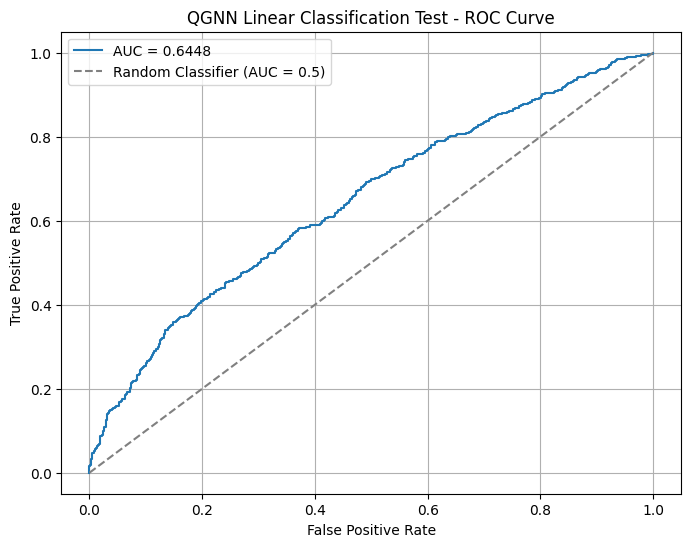

Confusion Matrix:
[[597 345]
 [398 535]]


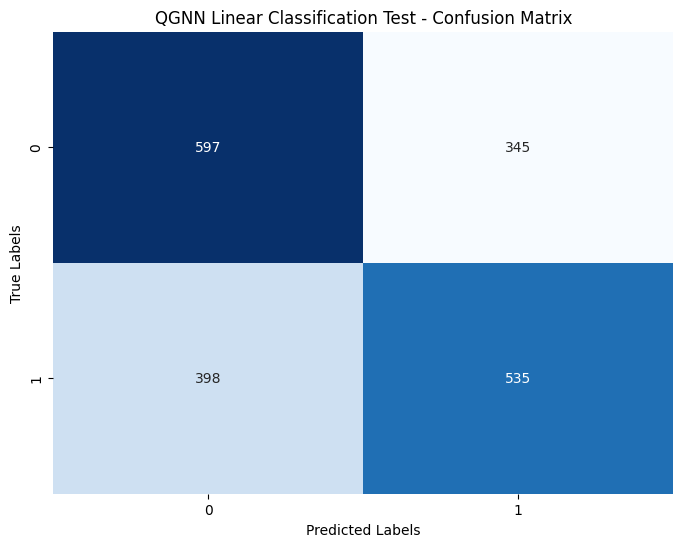

In [28]:
## Linear Classification Test
# Train a simple linear classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Compute accuracy of the linear classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")
# wandb.log({"QGNN Linear Classifier Test Accuracy": f"{accuracy * 100:.2f}%"})

# Compute the AUC score and plot the ROC curve
if len(np.unique(y_test)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"QGNN AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    
    # Add the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")
    
    # Label the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("QGNN Linear Classification Test - ROC Curve")
    plt.legend()
    plt.grid(True)
    
    # Save and log the plot to WandB
    plt.savefig("roc_curve.png")
    # wandb.log({"QGNN ROC Curve": wandb.Image("roc_curve.png")})
    
    # Show the plot (optional)
    plt.show()

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('QGNN Linear Classification Test - Confusion Matrix')

# Save and log the confusion matrix plot to WandB
plt.savefig("confusion_matrix.png")
# wandb.log({"QGNN Confusion Matrix": wandb.Image("confusion_matrix.png")})

plt.show()